Training an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.



In [ ]:
from IPython.display import clear_output

In [ ]:
%pip install torch torchvision
%pip install matplotlib

clear_output()

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch import optim
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

In [2]:
transforming = transforms.Compose([
    transforms.ToTensor()
    ,transforms.Normalize((0.5,), (0.5,))
    ,transforms.Resize((28,28))
])

In [3]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True,transform=transforming)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False,transform=transforming)

100%|██████████| 561753746/561753746 [00:19<00:00, 28621234.01it/s]


Extracting emnist_data/EMNIST/raw/gzip.zip to emnist_data/EMNIST/raw


In [ ]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)
demo_img, demo_label = train_data[10]

print(demo_label)

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


In [5]:
from torch.optim import Adam


In [4]:
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [6]:
def show(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [7]:
print("number of train data examples: {}".format(len(train_data)))
print("number of test data examples: {}".format(len(test_data)))

number of train data examples: 697932
number of test data examples: 116323


35


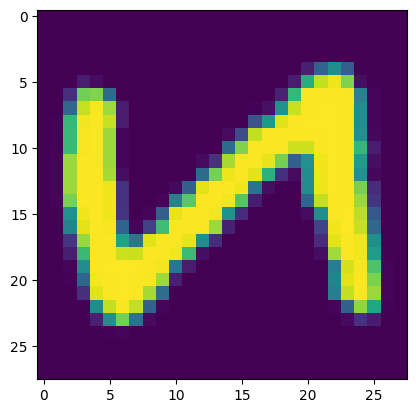

36


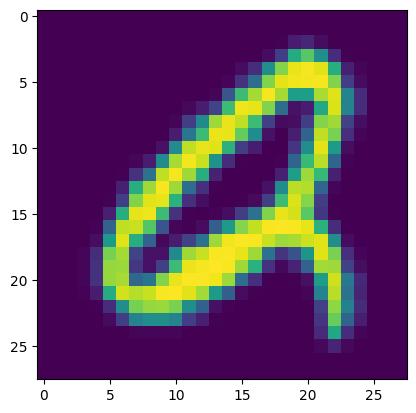

6


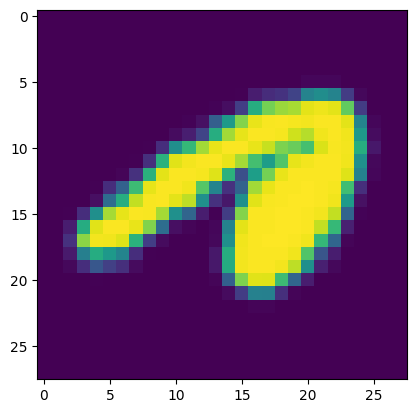

3


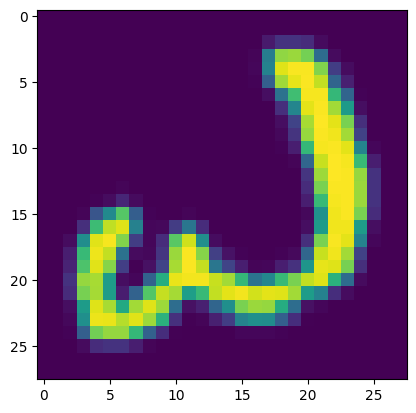

22


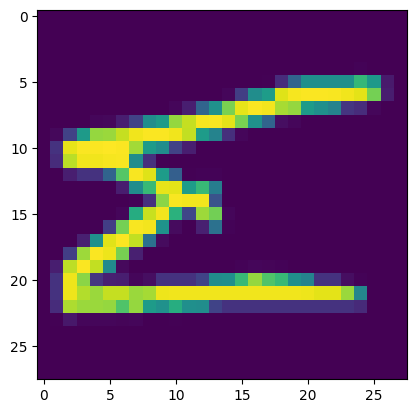

In [8]:
show(train_loader)

#Build Neural Network

In [9]:
class NN1Layer(nn.Module):

  def __init__(self, num_inp, num_out):

    super(NN1Layer, self).__init__()

    self.layer_1 = nn.Linear(num_inp, num_out)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

    z = self.layer_1(x)
    a = self.softmax(z)

    return a



class NN2Layer(nn.Module):

  def __init__(self, num_inp, num_hidden, num_out):

    super(NN2Layer, self).__init__()

    self.layer_1 = nn.Linear(num_inp, num_hidden)
    self.layer_2 = nn.Linear(num_hidden, num_out)

    self.hidden_activation = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

    z1 = self.layer_1(x)
    a1 = self.hidden_activation(z1)

    z2 = self.layer_2(a1)
    a2 = self.softmax(z2)

    return a2

In [10]:
# increase the number of epoches for a better model (it is going to take some time)
num_epochs = 10
lr = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_losses = []
val_losses = []

model = NN2Layer(28*28,128, 62)
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

model.to(device)

print(f'Using device {device}')

Using device cuda


In [ ]:
model.eval()
correctly_labelled = 0

with torch.no_grad():

  val_epoch_weighted_loss = 0

  for val_batch_X, val_batch_y in test_loader:

    val_batch_X = val_batch_X.view(-1, 28*28).to(device)
    val_batch_y = val_batch_y.to(device)

    val_batch_y_probs = model(val_batch_X)
    loss = criterion(val_batch_y_probs, val_batch_y)
    val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

    val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

    correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
val_losses.append(val_epoch_loss)

print(f'val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')


val_loss=4.127206264562847. labelled 2466/116323 correctly (2.1199590794597802% accuracy)


In [11]:
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.view(-1, 28*28).to(device)  # convert to [N, 28*28] shape where N is batch_size
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()  # need to clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)



  model.eval()
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.view(-1, 28*28).to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')

Epoch: 0, train_loss=3.6975868845051822, val_loss=3.6538784200817664. labelled 58827/116323 correctly (50.57211385538544% accuracy)
Epoch: 1, train_loss=3.6385969589244964, val_loss=3.6204600427322955. labelled 62717/116323 correctly (53.916250440583546% accuracy)
Epoch: 2, train_loss=3.599496968348661, val_loss=3.5811183205380384. labelled 67281/116323 correctly (57.83980812049207% accuracy)
Epoch: 3, train_loss=3.5762455265577877, val_loss=3.5626178638887724. labelled 69439/116323 correctly (59.69498723382306% accuracy)
Epoch: 4, train_loss=3.559898300704571, val_loss=3.5556795445076195. labelled 70131/116323 correctly (60.28988248239815% accuracy)
Epoch: 5, train_loss=3.5533419829745325, val_loss=3.545839917765008. labelled 71288/116323 correctly (61.28452670581055% accuracy)
Epoch: 6, train_loss=3.5435241606481966, val_loss=3.541108882422194. labelled 71799/116323 correctly (61.723820740524225% accuracy)
Epoch: 7, train_loss=3.539677311811242, val_loss=3.53819747055083. labelled 72

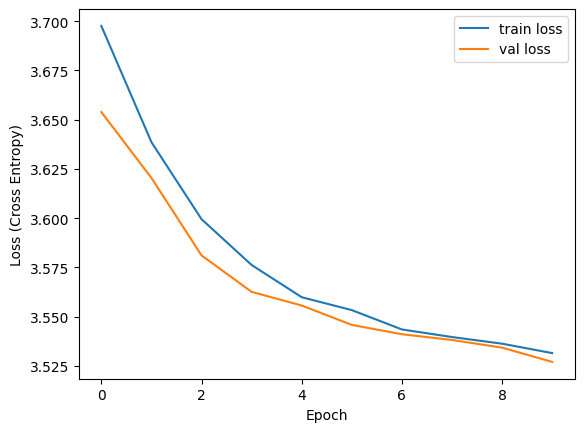

In [12]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

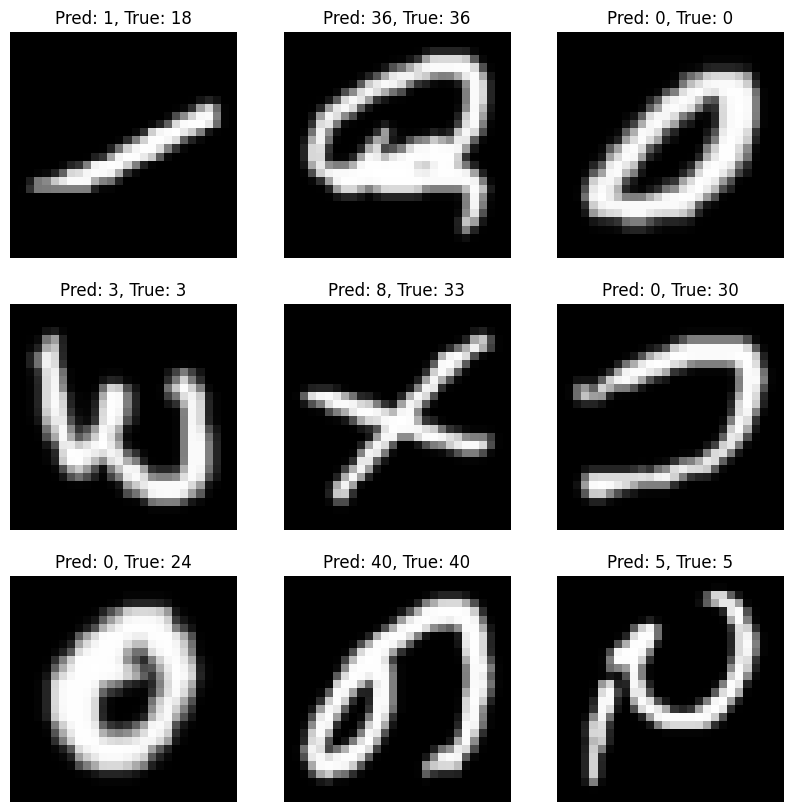

In [13]:
# Plot some predictions
model.eval()
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

with torch.no_grad():
    for i, (img, label) in enumerate(test_data):
        if i == 9:
            break
        ax = axes[i//3, i%3]
        img = img.view(1, 28*28).to(device)
        output = model(img)
        _, pred = torch.max(output, 1)
        ax.imshow(img.cpu().view(28, 28), cmap='gray')
        ax.set_title(f'Pred: {pred.item()}, True: {label}')
        ax.axis('off')

plt.show()

#Build CNN

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.Flatten(),

            nn.Linear(1568, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 62)
        )

    def forward(self, x):
        return self.model(x)

CNN_MODEL = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CNN_MODEL = CNN_MODEL.to(device)

In [44]:
optimizer = optim.Adam(CNN_MODEL.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [45]:
num_epochs = 10

train_loss_history = list()
val_loss_history = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CNN_MODEL.to(device)

for epoch in range(num_epochs):
    CNN_MODEL.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = CNN_MODEL(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    val_loss = 0.0
    val_correct = 0
    CNN_MODEL.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = CNN_MODEL(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 71.22% training loss: 0.94777
Epoch 1 validation accuracy: 83.05% validation loss: 0.49470
Epoch 2 training accuracy: 76.95% training loss: 0.72136
Epoch 2 validation accuracy: 83.73% validation loss: 0.46264
Epoch 3 training accuracy: 78.35% training loss: 0.67056
Epoch 3 validation accuracy: 84.18% validation loss: 0.44449
Epoch 4 training accuracy: 79.26% training loss: 0.63937
Epoch 4 validation accuracy: 84.41% validation loss: 0.43739
Epoch 5 training accuracy: 79.86% training loss: 0.61688
Epoch 5 validation accuracy: 84.54% validation loss: 0.42914
Epoch 6 training accuracy: 80.22% training loss: 0.60393
Epoch 6 validation accuracy: 84.76% validation loss: 0.42567
Epoch 7 training accuracy: 80.58% training loss: 0.59047
Epoch 7 validation accuracy: 85.04% validation loss: 0.41628
Epoch 8 training accuracy: 80.88% training loss: 0.57901
Epoch 8 validation accuracy: 85.04% validation loss: 0.41490
Epoch 9 training accuracy: 81.06% training loss: 0.57304

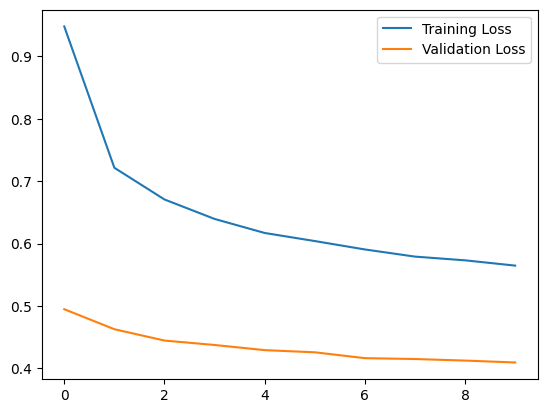

In [46]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [47]:
def model_test():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    CNN_MODEL.to(device)
    CNN_MODEL.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = CNN_MODEL(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            test_correct += (preds == labels).sum().item()
            test_loss += loss.item()
    print(f'test accuracy: {test_correct/len(test_loader):.2f}% test loss: {test_loss/len(test_loader):.5f}')

In [41]:
model_test()

test accuracy: 85.35% test loss: 0.40696


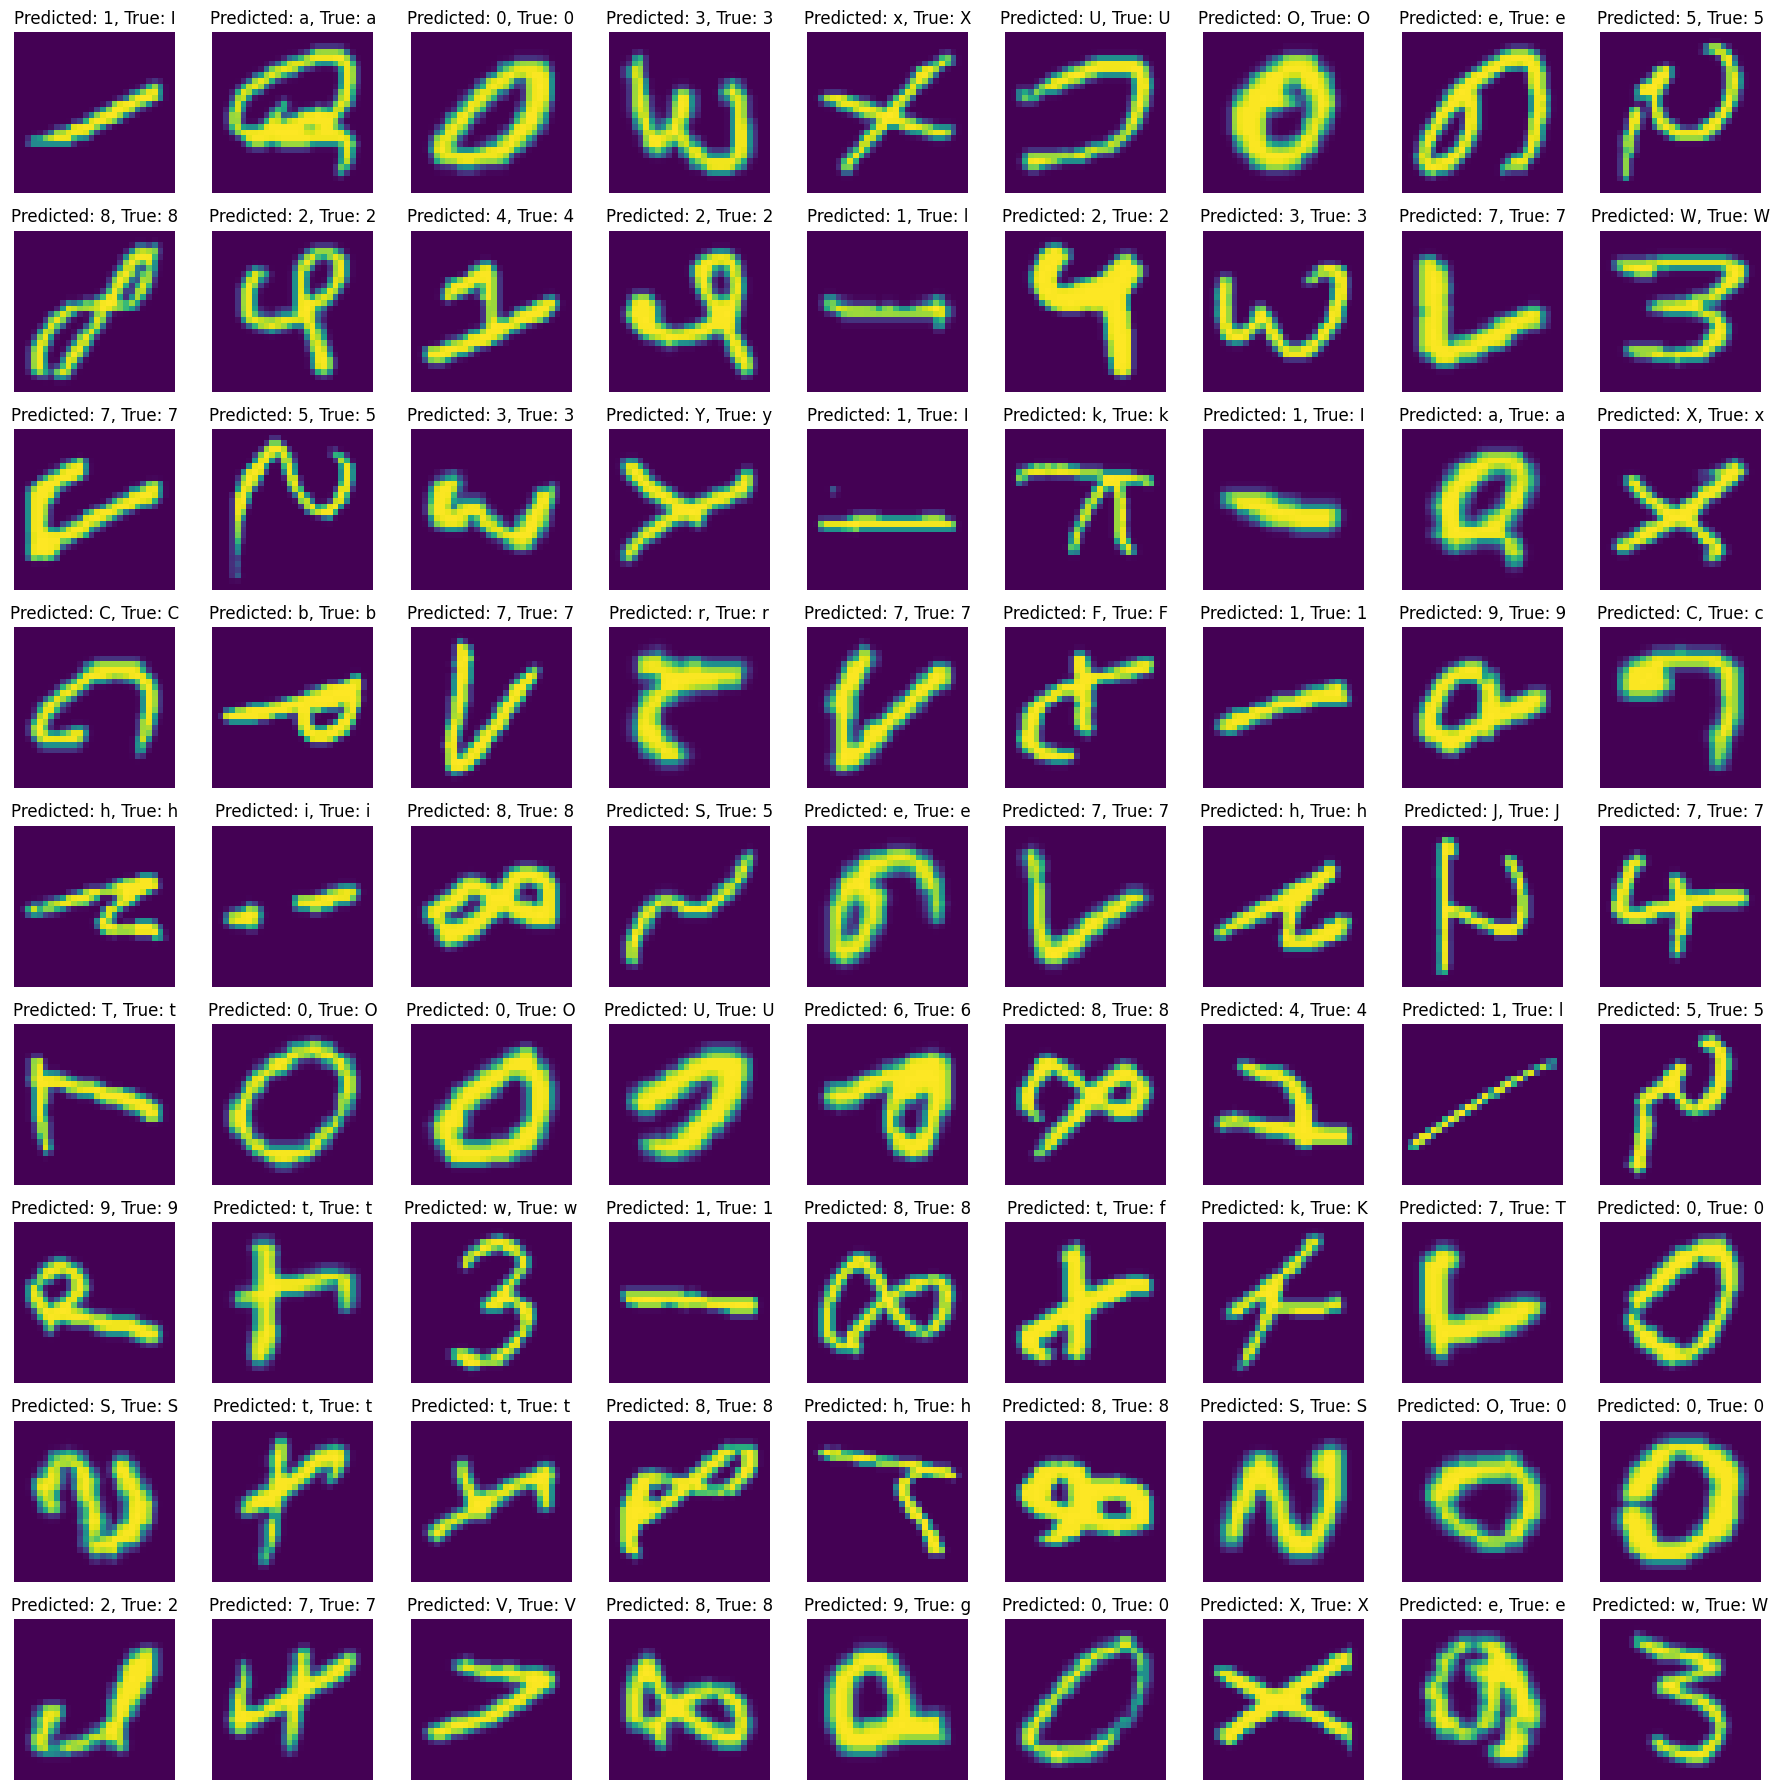

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your CNN model and test data ready
CNN_MODEL.eval()
with torch.no_grad():
    inputs, labels = next(iter(test_loader))

    inputs = inputs.to(device)

    outputs = CNN_MODEL(inputs)
    _, preds = torch.max(outputs, 1)

    all_labels = list(range(10)) + [chr(i) for i in range(ord('A'), ord('Z')+1)] + [chr(i) for i in range(ord('a'), ord('z')+1)]

    fig, axs = plt.subplots(9, 9, figsize=(18, 18))
    for i in range(81):
        ax = axs[i // 9, i % 9]
        ax.imshow(inputs[i].cpu().permute(1, 2, 0))
        ax.set_title(f"Predicted: {all_labels[preds[i].item()]}, True: {all_labels[labels[i].item()]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()